# **Image classification using CNN**

In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import MNIST, SVHN
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA is {'' if torch.cuda.is_available() else 'not '}available")

CUDA is not available


## **Load the SVHN dataset**

In [2]:
train_dataset = SVHN(
    root="./data/svhn/train",
    split='train',
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

test_dataset = SVHN(
    root="./data/svhn/test",
    split='test',
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

extra_dataset = SVHN(
    root="./data/svhn/extra",
    split='extra',
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

24.0%

Combine the train and extra dataset to form a larger one

In [99]:
train_dataset.data = np.concatenate(
    (train_dataset.data, extra_dataset.data[:70000]), axis=0
)

train_dataset.labels = np.concatenate(
    (train_dataset.labels, extra_dataset.labels[:70000]), axis=0
)

In [100]:
print(train_dataset.data.shape)
print(train_dataset.labels.shape)

(143257, 3, 32, 32)
(143257,)


Helper functions 

In [101]:
def one_hot(data):
    return nn.functional.one_hot(data, num_classes=10).float()

def load_data(data, batch_size):
    return DataLoader(
        dataset=data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=0
    )

def score(model, dataloader, loss_fun=None):
    model = model.eval()
    correct = 0.0
    total = 0
    loss = 0.0

    with torch.inference_mode():
        for idx, (data, labels) in enumerate(dataloader):
            data = data.to(device)
            labels = labels.to(device)
            y_model = model(data)
            predictions = torch.argmax(y_model, dim=1)
            correct += (labels == predictions).sum().item()
            total += labels.size(0)

            if not loss_fun:
                continue
            loss += loss_fun(y_model, one_hot(labels)).item()

    return correct / total, loss

## **Build the CNN model**

In [52]:
class CNN(nn.Module):
    def __init__(self,
                 input_channels,
                 conv_output,
                 hidden_neurons,
                 output_neurons,
                 kernel_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=input_channels,
            out_channels=conv_output,
            kernel_size=3,
            padding=1
        )
        self.conv_output = conv_output
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(conv_output * 16 * 16, hidden_neurons, bias=True)
        self.fc2 = nn.Linear(hidden_neurons, output_neurons, bias=True)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, self.conv_output * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## **Training phase**

Techniques used to train:
- **k-Fold Cross Validation**
- **Early stopping** based on validation loss, to prevent **overfitting**
- **Learning rate scheduling** to facilitate convergence even at later stages where weight adjustments seem to stagnate
- **Weighted Cross Entropy Loss** to compensate for the imbalanced dataset
- **Fine tuning** via the exploration of different combinations of parameters. The **parameters** used to fine tune are:
    1. number of neurons in the hidden layer
    2. learning rate
    3. batch size
    4. number of convolutional filters

In [63]:
def train(
    model,
    train_data,
    test_data,
    k_folds,
    batch,
    optimizer,
    loss_function,
    lr_scheduler,
    device="cpu",
    patience=3,
    verbose=True,
):
    nsamples = len(train_data)
    fold_indices = torch.arange(nsamples)
    fold_size = nsamples // k_folds

    scores = {
        "Training": [],
        "Validation": [],
        "Test": []
    }

    losses = {
        "Training": [],
        "Validation": [],
        "Test": []
    }

    for fold in range(k_folds):
        best_validation_loss = float("inf")
        current_patience = 0

        start_index = fold * fold_size
        stop_index = min((fold + 1) * fold_size, nsamples)

        validation_indices = fold_indices[start_index:stop_index]
        train_indices = torch.cat([
            fold_indices[:start_index],
            fold_indices[stop_index:]
        ])

        train_subset = Subset(train_data, train_indices)
        validation_subset = Subset(train_data, validation_indices)

        train_loader = load_data(train_subset, batch)
        validation_loader = load_data(validation_subset, batch)
        test_loader = load_data(test_data, batch)

        for epoch in range(num_epochs):
            model.train()
            loss = 0.0
            correct = 0;
            total = 0;

            for X, y in train_loader:
                X = X.to(device)
                y = y.to(device)
                y_hot = one_hot(y)

                optimizer.zero_grad()
                y_model = model(X)
                batch_loss = loss_function(y_model, y_hot)
                batch_loss.backward()
                optimizer.step()
                loss += batch_loss.item()
                
                predictions = torch.argmax(y_model, dim=1)
                correct += (y == predictions).sum().item()
                total += y.size(0)

            lr_scheduler.step(loss)
            model.eval()

            training_score = correct / total
            
            validation_score, validation_loss = score(
                model, validation_loader, loss_function
            )
            test_score, test_loss = score(
                model, test_loader, loss_function
            )

            scores["Training"].append(training_score)
            scores["Validation"].append(validation_score)
            scores["Test"].append(test_score)

            losses["Training"].append(loss)
            losses["Validation"].append(validation_loss)
            losses["Test"].append(test_loss)

            if validation_loss < best_validation_loss:
                best_validation_loss = validation_loss
                current_patience = 0
            else:
                current_patience += 1
                if current_patience >= patience:
                    print(f"Early stopping: Validation loss didn't improve for "
                          f"{current_patience} epochs.\n")
                    break

            if not verbose:
                continue

            print(f"Epoch: {epoch}/{num_epochs}")
            print(f"Loss: {loss:.2f}")
            print(f"Training: {training_score}")
            print(f"Validation: {validation_score}")
            print(f"Test: {test_score}\n")

    return scores, losses, model

Select training parameters

In [102]:
from sklearn.utils.class_weight import compute_class_weight

k_folds = 5
input_size = 32 * 32 * 3
batch_size = 256
hidden_neurons = 512
learning_rate = 0.0005
filters = 32
output_size = 10
num_epochs = 15
patience = 4
kernel = 4

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_dataset.labels),
    y=train_dataset.labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

Train for different combinations of parameters

In [65]:
print(f"\nTraining model with hidden_neurons={hidden_neurons}, "
        f"batch={batch_size}, lr={learning_rate}, "
        f"filters={filters}")

cnnmodel = CNN(
    input_channels=3,
    conv_output=filters,
    hidden_neurons=hidden_neurons,
    output_neurons=output_size,
    kernel_size=kernel
).to(device)

loss_function = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(
    cnnmodel.parameters(),
    lr=learning_rate
)

scheduler = ReduceLROnPlateau(
    optimizer,
    factor=0.3,
    patience=2,
    verbose=True
)

start = time.time()

scores, losses, cnnmodel = train(
    cnnmodel,
    train_dataset,
    test_dataset,
    k_folds,
    batch_size,
    optimizer,
    loss_function,
    scheduler,
    device,
    patience,
    verbose=True
)

end = time.time()
print(f"\nTraining duration: {end - start}\n")


Training model with hidden_neurons=512, batch=256, lr=0.0005, filters=32
Epoch: 0/15
Loss: 526.68
Training: 0.6450730564876958
Validation: 0.7790681306306306
Test: 0.7735535272277227

Epoch: 1/15
Loss: 244.59
Training: 0.8510206935123042
Validation: 0.8216497747747747
Test: 0.8119972153465347

Epoch: 2/15
Loss: 197.45
Training: 0.8805141918344519
Validation: 0.8428350225225225
Test: 0.8321859529702971

Epoch: 3/15
Loss: 172.13
Training: 0.8951953998881432
Validation: 0.8460726351351351
Test: 0.834583849009901

Epoch: 4/15
Loss: 154.66
Training: 0.9047381851230425
Validation: 0.8616624436936937
Test: 0.8487391707920792

Epoch: 5/15
Loss: 141.03
Training: 0.9139751118568232
Validation: 0.8590934684684685
Test: 0.8487391707920792

Epoch: 6/15
Loss: 130.85
Training: 0.9185979446308725
Validation: 0.8604307432432432
Test: 0.8528774752475248

Epoch: 7/15
Loss: 120.82
Training: 0.9246976370246085
Validation: 0.8644425675675675
Test: 0.8565516707920792

Epoch: 8/15
Loss: 112.37
Training: 0.92

# **Visualize the results**

In [ ]:
extra_dataset.data = extra_dataset.data[270000:425000]
extra_dataset.labels = extra_dataset.labels[270000:425000]
random_loader = load_data(extra_dataset, batch_size)

print(f"Score on unknown set: {score(cnnmodel, random_loader)[0]}")

In [67]:
import matplotlib.pyplot as plt

def plot(training_values, validation_values, metric):
    epoch_indices = torch.arange(len(training_values))

    plt.figure(figsize=(10, 6))
    plt.plot(
        epoch_indices,
        training_values,
        marker="o",
        label=f"{metric} on training data"
    )
    plt.plot(
        epoch_indices,
        validation_values,
        marker="s",
        label=f"{metric} on validation data"
    )
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

    plt.grid(True)
    plt.show()

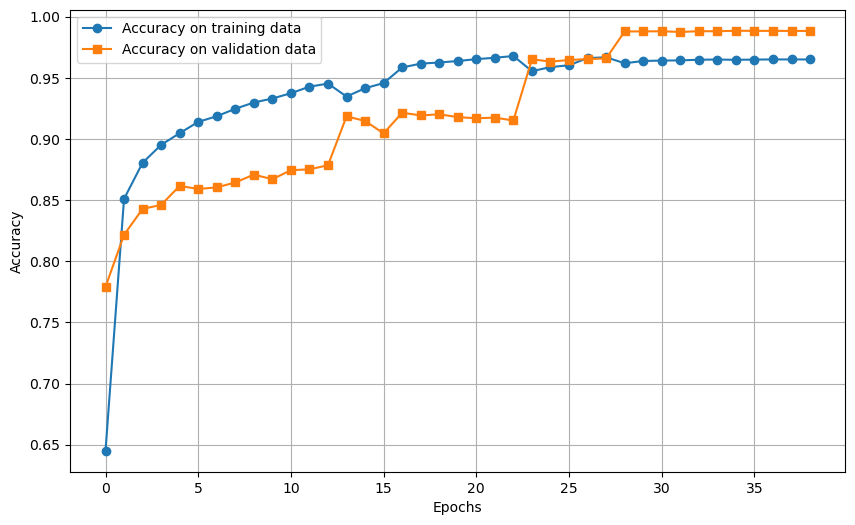

In [68]:
plot(scores["Training"], scores["Validation"], metric="Accuracy")

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, data, labels):
    with torch.inference_mode():
        predictions = torch.argmax(model(data), dim=1)

    cm = confusion_matrix(labels, predictions)
    class_labels = [str(i) for i in range(10)]
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

**Confusion Matrix** for the training dataset

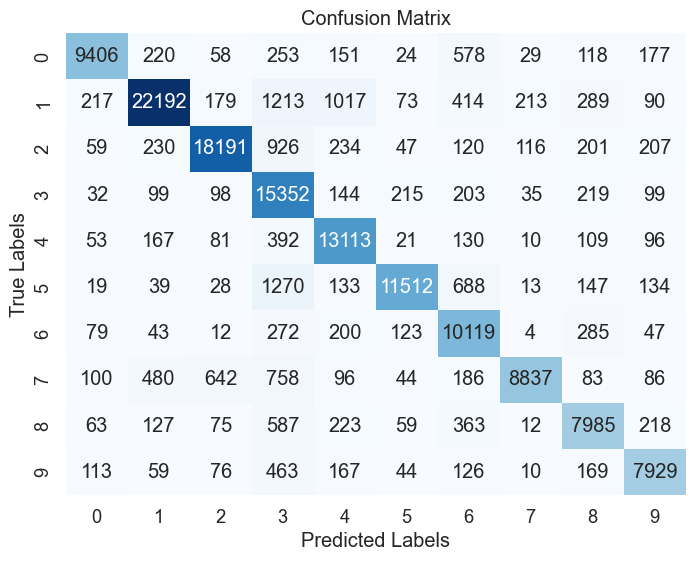

In [70]:
plot_confusion_matrix(
    cnnmodel.cpu(),
    torch.tensor(train_dataset.data).float(),
    train_dataset.labels
)

**Confusion Matrix** for the random dataset

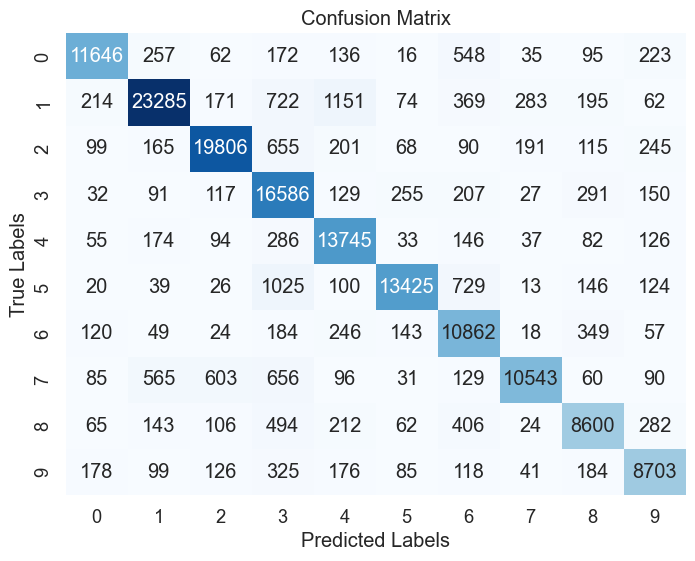

In [71]:
plot_confusion_matrix(
    cnnmodel.cpu(),
    torch.tensor(extra_dataset.data).float(),
    extra_dataset.labels
)

# **Classification using k-Nearest-Neighbors**

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

**Standardization** and **Dimensionality Reduction**

In [15]:
ncomponents = 800
pca = PCA(ncomponents, whiten=True)

In [33]:
train_loader = load_data(train_dataset, 2048)
reduced_data = []
scaler = StandardScaler()

for X, y in train_loader:
    X = X.numpy()
    X = X.reshape(X.shape[0], -1)
    X = scaler.fit_transform(X)
    X = pca.fit_transform(X)
    reduced_data.append(X)

reduced_data = np.concatenate(reduced_data, axis=0)
reduced_data.shape

(141312, 800)

In [34]:
extra_dataset.data.shape

(155000, 3, 32, 32)

In [35]:
extra_loader = load_data(extra_dataset, 2048)
random_reduced_data = []
scaler = StandardScaler()

for X, y in extra_loader:
    X = X.numpy()
    X = X.reshape(X.shape[0], -1)
    X = scaler.fit_transform(X)
    X = pca.fit_transform(X)
    random_reduced_data.append(X)

random_reduced_data = np.concatenate(random_reduced_data, axis=0)
random_reduced_data.shape

(153600, 800)

**kNN with k=1**

In [38]:
knnmodel = KNeighborsClassifier(n_neighbors=1)
knnmodel.fit(reduced_data, train_dataset.labels[:reduced_data.shape[0]])

KNeighborsClassifier(n_neighbors=1)

In [36]:
y_pred = knnmodel.predict(reduced_data)
accuracy = np.mean(y_pred == train_dataset.labels[:reduced_data.shape[0]])
print(f'Accuracy with k=1: {accuracy:.2f}')

Accuracy with k=1: 1.00


In [39]:
y_pred = knnmodel.predict(random_reduced_data)
accuracy = np.mean(y_pred == extra_dataset.labels[random_reduced_data.shape[0]])
print(f'Accuracy on unknown dataset: {accuracy:.2f}')

Accuracy on unknown dataset: 0.10


**kNN with k=3**

In [37]:
knnmodel2 = KNeighborsClassifier(n_neighbors=3)
knnmodel2.fit(reduced_data, train_dataset.labels[:reduced_data.shape[0]])

KNeighborsClassifier(n_neighbors=3)

In [38]:
y_pred = knnmodel2.predict(reduced_data)
accuracy = np.mean(y_pred == train_dataset.labels[:reduced_data.shape[0]])
print(f'Accuracy with k=3: {accuracy:.2f}')

Accuracy with k=3: 0.44


# **Classification using Nearest Centroid**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score

In [157]:
standardized_data = train_dataset.data / 255.0 * 2.0 - 1.0
standardized_data.shape

(73257, 3, 32, 32)

In [158]:
standardized_data = standardized_data.reshape(standardized_data.shape[0], -1)
standardized_data.shape

(73257, 3072)

In [159]:
ncmodel = NearestCentroid()
ncmodel.fit(standardized_data, train_dataset.labels)

NearestCentroid()

In [160]:
y_pred = ncmodel.predict(standardized_data)

In [161]:
(y_pred == train_dataset.labels).sum().item() / standardized_data.shape[0]

0.11462385847086286